In [34]:
%load_ext autoreload
%autoreload 2

from toolz import take
import torch as th
from torch.utils.data import DataLoader
from torch import tensor, optim, nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline

from wxml.model import MLP
from wxml.hamming import make_data_hamming, wt, bittensor, bittensor8, bitvector8, bin_to_dec
from wxml.data import make_splits
from wxml.train import train, count_matches

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
batch_size = 32
n_batches = 256
assert batch_size * n_batches == 8192

n_test = 1024

xs, ys = make_data_hamming(batch_size * n_batches)
xs_test_ood, ys_test_ood = make_data_hamming(n_test, k=(65, 255))

[print(xy) for xy in take(5, zip(xs, ys))]

ds_train, ds_test = make_splits(xs, ys)
# train_loader, val_loader, test_loader = [DataLoader(d, batch_size=batch_size, shuffle=False) for d in [ds_train, ds_val, ds_test]]
train_loader, test_loader = [DataLoader(d, batch_size=batch_size, shuffle=False) for d in [ds_train, ds_test]]
test_loader_ood = DataLoader(list(zip(xs_test_ood, ys_test_ood)), batch_size=batch_size, shuffle=False)


(tensor([0., 0., 0., 1., 1., 1., 0., 0.], requires_grad=True), tensor([0., 0., 0., 0., 0., 0., 1., 1.], requires_grad=True))
(tensor([0., 0., 1., 1., 1., 1., 0., 0.], requires_grad=True), tensor([0., 0., 0., 0., 0., 1., 0., 0.], requires_grad=True))
(tensor([0., 0., 0., 0., 0., 1., 1., 0.], requires_grad=True), tensor([0., 0., 0., 0., 0., 0., 1., 0.], requires_grad=True))
(tensor([0., 0., 1., 1., 0., 0., 1., 0.], requires_grad=True), tensor([0., 0., 0., 0., 0., 0., 1., 1.], requires_grad=True))
(tensor([0., 0., 1., 0., 1., 1., 0., 1.], requires_grad=True), tensor([0., 0., 0., 0., 0., 1., 0., 0.], requires_grad=True))


In [39]:
num_layers = 2
input_dim = 8
hidden_dim = 32
output_dim = 8

lr = 1e-3

epochs = 50

model = nn.Sequential(MLP(num_layers, input_dim, hidden_dim, output_dim), nn.Sigmoid())
opt = optim.Adam(model.parameters(), lr=lr)
loss_fn = F.binary_cross_entropy

results = train(model, loss_fn, opt, train_loader, test_loader, epochs=epochs, device='mps', dtype=th.float32, print_every=n_batches // 10)


  0%|          | 0/50 [00:00<?, ?it/s]

epoch=0 | train_loss=0.3630 | val_loss=0.2389 | train_acy=0.8241 | val_acy=0.8705
epoch=1 | train_loss=0.2078 | val_loss=0.1846 | train_acy=0.9056 | val_acy=0.9186
epoch=2 | train_loss=0.1705 | val_loss=0.1626 | train_acy=0.9257 | val_acy=0.9269
epoch=3 | train_loss=0.1542 | val_loss=0.1511 | train_acy=0.9338 | val_acy=0.9375
epoch=4 | train_loss=0.1439 | val_loss=0.1403 | train_acy=0.9423 | val_acy=0.9408
epoch=5 | train_loss=0.1329 | val_loss=0.1278 | train_acy=0.9472 | val_acy=0.9450
epoch=6 | train_loss=0.1208 | val_loss=0.1152 | train_acy=0.9551 | val_acy=0.9616
epoch=7 | train_loss=0.1086 | val_loss=0.1031 | train_acy=0.9620 | val_acy=0.9716
epoch=8 | train_loss=0.0970 | val_loss=0.0921 | train_acy=0.9666 | val_acy=0.9757
epoch=9 | train_loss=0.0865 | val_loss=0.0819 | train_acy=0.9743 | val_acy=0.9804
epoch=10 | train_loss=0.0765 | val_loss=0.0720 | train_acy=0.9804 | val_acy=0.9860
epoch=11 | train_loss=0.0669 | val_loss=0.0624 | train_acy=0.9855 | val_acy=0.9875
epoch=12 | tra

In [43]:
num_layers = 2
input_dim = 8
hidden_dim = 32
output_dim = 8

lr = 1e-3

epochs = 50

model = nn.Sequential(MLP(num_layers, input_dim, hidden_dim, output_dim), nn.Sigmoid())
opt = optim.Adam(model.parameters(), lr=lr)
loss_fn = F.binary_cross_entropy

results_ood = train(model, loss_fn, opt, train_loader, test_loader_ood, epochs=epochs, device='mps', dtype=th.float32, print_every=n_batches // 10)

  0%|          | 0/50 [00:00<?, ?it/s]

epoch=0 | train_loss=0.3713 | val_loss=0.2895 | train_acy=0.8076 | val_acy=0.7761
epoch=1 | train_loss=0.2214 | val_loss=0.3089 | train_acy=0.8873 | val_acy=0.7980
epoch=2 | train_loss=0.1804 | val_loss=0.3224 | train_acy=0.9227 | val_acy=0.8110
epoch=3 | train_loss=0.1509 | val_loss=0.3756 | train_acy=0.9333 | val_acy=0.8110
epoch=4 | train_loss=0.1280 | val_loss=0.4541 | train_acy=0.9483 | val_acy=0.8080
epoch=5 | train_loss=0.1073 | val_loss=0.5990 | train_acy=0.9691 | val_acy=0.7944
epoch=6 | train_loss=0.0855 | val_loss=0.7832 | train_acy=0.9855 | val_acy=0.7839
epoch=7 | train_loss=0.0718 | val_loss=0.9470 | train_acy=0.9863 | val_acy=0.7823
epoch=8 | train_loss=0.0624 | val_loss=1.0837 | train_acy=0.9862 | val_acy=0.7802
epoch=9 | train_loss=0.0549 | val_loss=1.2106 | train_acy=0.9867 | val_acy=0.7816
epoch=10 | train_loss=0.0484 | val_loss=1.4036 | train_acy=0.9888 | val_acy=0.7847
epoch=11 | train_loss=0.0423 | val_loss=1.5352 | train_acy=0.9918 | val_acy=0.7797
epoch=12 | tra

In [53]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

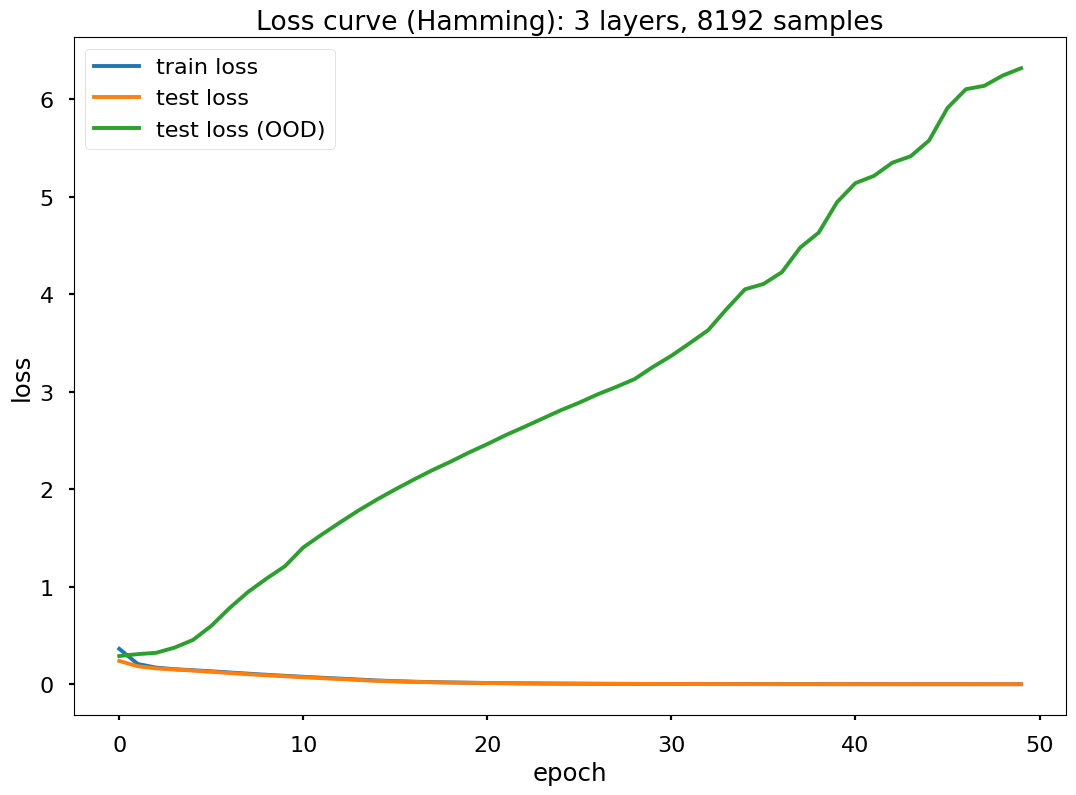

In [57]:
plt.style.use('seaborn-v0_8-poster')

plt.plot(results['train_losses'], label='train loss')
plt.plot(results['val_losses'], label='test loss')
plt.plot(results_ood['val_losses'], label='test loss (OOD)')
# plt.title("BCE Loss of 2-layer MLP on Hamming weight data using AdamW")
plt.title("Loss curve (Hamming): 3 layers, 8192 samples")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

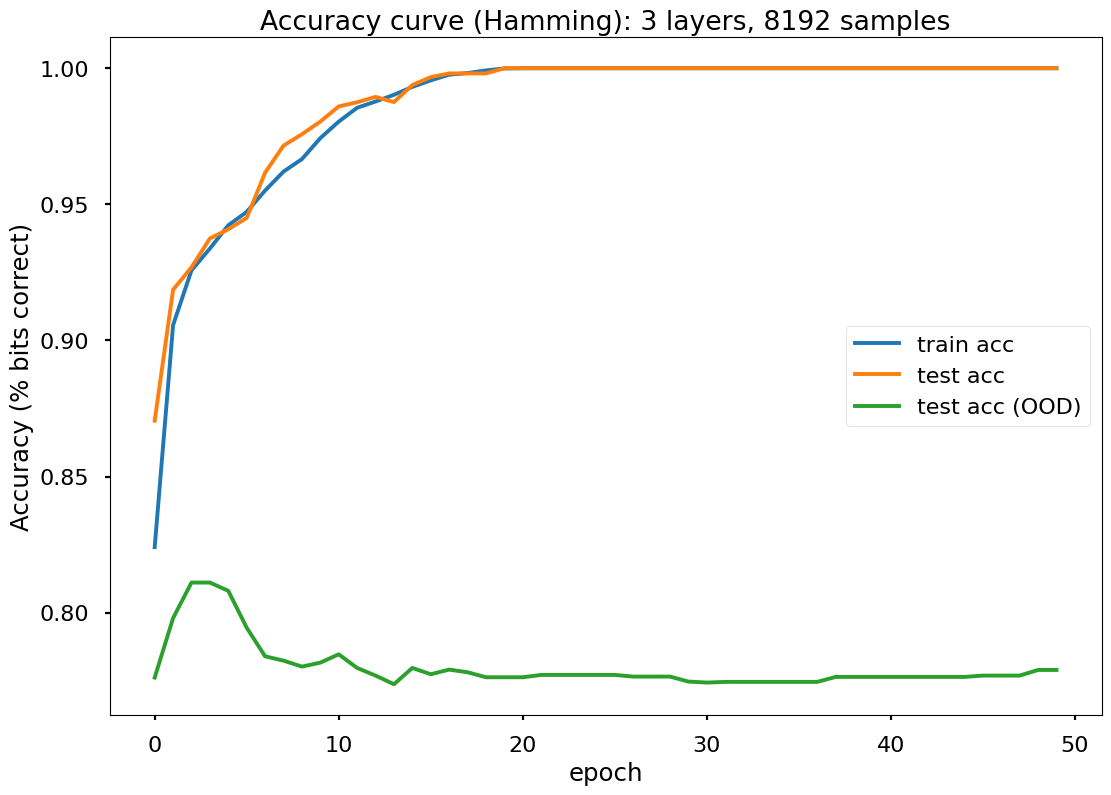

In [55]:
plt.style.use('seaborn-v0_8-poster')

plt.plot(results['train_accuracies'], label='train acc')
plt.plot(results['val_accuracies'], label='test acc')
plt.plot(results_ood['val_accuracies'], label='test acc (OOD)')
plt.title("Accuracy curve (Hamming): 3 layers, 8192 samples")
plt.ylabel("Accuracy (% bits correct)")
plt.xlabel("epoch")
plt.legend()
plt.show()

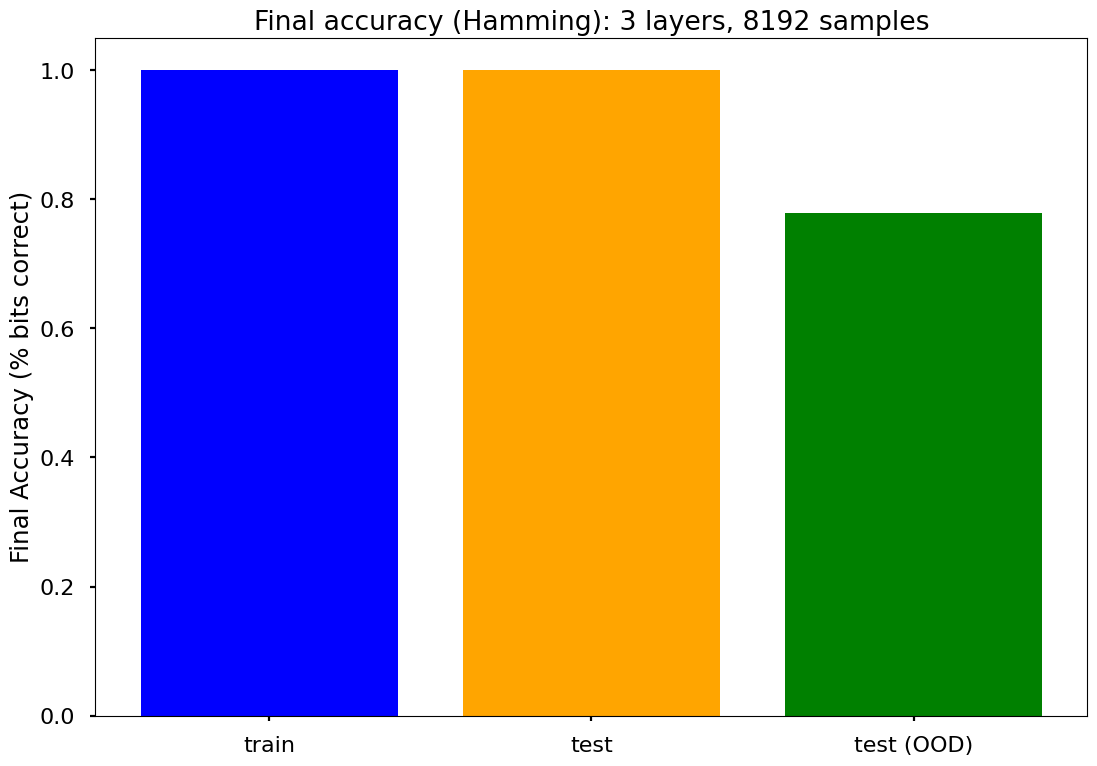

In [61]:
plt.style.use('seaborn-v0_8-poster')

final_train_acc = results['train_accuracies'][-1]
final_test_acc = results['val_accuracies'][-1]
final_test_ood_acc = results_ood['val_accuracies'][-1]

plt.bar(['train', 'test', 'test (OOD)'], [final_train_acc, final_test_acc, final_test_ood_acc], color=['blue', 'orange', 'green'])
plt.ylabel("Final Accuracy (% bits correct)")
plt.title("Final accuracy (Hamming): 3 layers, 8192 samples")
plt.show()

In [ ]:
count_matches(bittensor(wt(x), n=8).to('mps'), (model(x).round()))

In [ ]:
bin_to_dec([0, 0, 0, 0, 0, 0, 1, 1])

In [ ]:
def count_divisible(N, ps):
    acc = [0, 1]
    for i in range(2, N):
        if any(i % p == 0 for p in ps):
            acc.append(i)
    return acc

In [ ]:
n = 1000

def is_prime(x):
    return all(x % i != 0 for i in range(2, x))

def primes(n):
    acc = []
    i = 2
    while len(acc) < n:
        if is_prime(i):
            acc.append(i)
        i += 1
    return acc


acc = []
for i in range(n):
    acc.append(len(count_divisible(n, primes(i))))
    print(f"# primes: {i} | {acc[-1]}/{n}")

In [ ]:
plt.plot(acc)
plt.title("Number of numbers divisible by primes")
plt.xlabel("# primes")
plt.ylabel("# divisible")

In [ ]:
# TODO

def rounded(xs):
    return [round(x, 4) for x in xs]

def round01(x):
    return x.round()

th.set_printoptions(sci_mode=False, precision=4)

# x, bin(x), wt(bin(x)), bin(wt(bin(x))), f(x), round(f(x)), wt(round(f(x))), bin(wt(round(f(x))), n
print("x | bin(x) | wt(bin(x)) | bin(wt(bin(x))) | f(bin(x)) | round(f(x)) | base10(round(f(x))) | n")
for x in range(256):
    # bin_x = bittensor(x, 8).int().tolist()
    bin_x = bittensor8(x)
    wt_bin_x = wt(bin_x)
    bin_wt_bin_x = bittensor8(wt_bin_x)
    f_x = model(bin_x.to('mps'))
    round_f_x = round01(f_x)
    base10_round_f_x = bin_to_dec(round_f_x.int().tolist())
    n = 8 - count_matches(round_f_x.to('mps'), bin_wt_bin_x.to('mps'))
    print(f"{x} | {bin_x.int().tolist()} | {wt_bin_x.int().tolist()} | {bin_wt_bin_x.int().tolist()} | {rounded(f_x.tolist())} | {round_f_x.int().tolist()} | {base10_round_f_x} | {n}")

In [ ]:
# TODO: get accuracy for hamming weights not in train set
# TODO: make validation set contains hamming weights not in train set
# TODO: Hypothesis: the NN can only learn bitvectors up to a certain length

x = tensor([[0, 0, 0, 0, 0, 0, 1, 1]], device='mps').float()

th.set_printoptions(sci_mode=False)
with th.no_grad():
    print(model(x))